In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [62]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [63]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [64]:
#create variable that includes total number of baths to see if this improves the model
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']
#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']
#variable that gets the toal square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

# OLS Regression

In [65]:
# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [66]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     737.0
Date:                Sat, 20 Jul 2019   Prob (F-statistic):               0.00
Time:                        22:16:04   Log-Likelihood:                 476.60
No. Observations:                1168   AIC:                            -935.2
Df Residuals:                    1159   BIC:                            -889.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.1827      0.557     11.097      0.000       5.090       7.276
overallqual      0.1058      0.006     18.993      0.000       0.095       0.117
grlivarea     7.045e-05   1.95e-05      3.606      0.000    3.21e-05       0.000
garagecars       0.0893      0.008     10.604      0.000       0.073       0.106
totalsf          0.0001    1.3e-05      7.964      0.000    7.77e-05       0.000
mszoning_FV      0.1305      0.027      4.839      0.000       0.078       0.183
mszoning_RL      0.1607      0.014     11.626      0.000       0.134       0.188
total_bath       0.0445      0.007      6.197      0.000       0.030       0.059
yearremodadd     0.0022      0.000      7.749      0.000       0.002       0.003
==============================================================================
Omnibus:                      748.588   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25841.587
Skew:                          -2.416   Prob(JB):                         0.00
Kurtosis:                      25.531   Cond. No.                     4.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I was able to get the model 'more accurate' in terms of better R-squared and lower error in the prediction, BUT the predictive value for the model continues to be very bad for higher end homes. At this point, it seems like more data would be needed to make this model better?

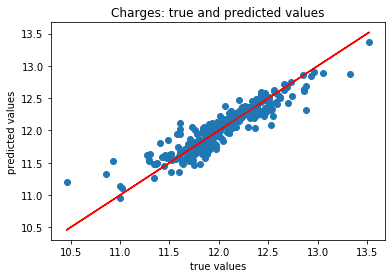

R-squared of the model in training set is: 0.8357162384890331
-----Test set statistics-----
R-squared of the model in test set is: 0.8555111224539024
Mean absolute error of the prediction is: 0.11199045805424093
Mean squared error of the prediction is: 0.024092891633249854
Root mean squared error of the prediction is: 0.15521885076642544
Mean absolute percentage error of the prediction is: 0.9381176923595602


In [68]:
# We add constant to the model as it's a best practice
# to do so every time!

lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)


X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


# Lasso Regression

In [9]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [10]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [12]:
#create variable that includes total number of baths to see if this improves the model
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']
#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']
#variable that gets the toal square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

In [24]:
# Y is the target variable
Y = np.log1p(df['saleprice'])

# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-100,100,10)]

In [25]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8357162384890333
-----Test set statistics-----
R-squared of the model in test set is: 0.855511122453901
Mean absolute error of the prediction is: 0.11199045805423744
Mean squared error of the prediction is: 0.0240928916332495
Root mean squared error of the prediction is: 0.1552188507664243
Mean absolute percentage error of the prediction is: 0.9381176923595302


In [26]:
lasso_cv = LassoCV(alphas=alphas, cv=10)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-60
R-squared of the model in training set is: 0.8357162384890333
-----Test set statistics-----
R-squared of the model in test set is: 0.855511122453904
Mean absolute error of the prediction is: 0.11199045805423873
Mean squared error of the prediction is: 0.02409289163324902
Root mean squared error of the prediction is: 0.15521885076642278
Mean absolute percentage error of the prediction is: 0.9381176923595403


# Ridge Regression

In [49]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [50]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

#create variable that includes total number of baths to see if this improves the model
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']
#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']
#variable that gets the toal square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

In [51]:
# Ridge Regression
# Y is the target variable
Y = np.log1p(df['saleprice'])

# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-100,100,10)]

In [52]:
# Ridge Regression

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8357162384890333
-----Test set statistics-----
R-squared of the model in test set is: 0.8555111224539226
Mean absolute error of the prediction is: 0.11199045805422976
Mean squared error of the prediction is: 0.024092891633245964
Root mean squared error of the prediction is: 0.15521885076641292
Mean absolute percentage error of the prediction is: 0.9381176923594631


# ElasticNet Regression

In [53]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [54]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

#create variable that includes total number of baths to see if this improves the model
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']
#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']
#variable that gets the toal square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

In [55]:
# Y is the target variable
Y = np.log1p(df['saleprice'])

# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
l1 = [.1, .5, .7, .9, .95, .99, 1]

In [59]:
# ElasticNet Regression

elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1) 
elastic_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8357162384890333
-----Test set statistics-----
R-squared of the model on the test set is: 0.855511122453904
Mean absolute error of the prediction is: 0.11199045805423873
Mean squared error of the prediction is: 0.02409289163324902
Root mean squared error of the prediction is: 0.15521885076642278
Mean absolute percentage error of the prediction is: 0.9381176923595403


The OLS model did best in r squared for the test set, but the Ridge model scored very slighly lower in several of the error calculations.